In [1]:
import os
import torch
import clip
import numpy as np
import pandas as pd
from PIL import Image
from urllib import request
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

/Users/harrywang/sandbox/tutorial-buffet/clip-image-classification/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# test m1 support
import torch
import math
# this ensures that the current MacOS version is at least 12.3+
print(torch.backends.mps.is_available())
# this ensures that the current current PyTorch installation was built with MPS activated.
print(torch.backends.mps.is_built())

True
True


In [3]:
# setup clip

device = "mps" if torch.backends.mps.is_available() else "cpu"
#device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

model, preprocess = clip.load("ViT-B/32", device=device)


mps


In [4]:
photos = pd.read_csv('photos-1k.csv')
photos.head()

,photo_id,photo_url,photo_image_url,photo_submitted_at,photo_featured,photo_width,photo_height,photo_aspect_ratio,photo_description,photographer_username,...,photo_location_country,photo_location_city,stats_views,stats_downloads,ai_description,ai_primary_landmark_name,ai_primary_landmark_latitude,ai_primary_landmark_longitude,ai_primary_landmark_confidence,blur_hash
0,XMyPniM9LF0,https://unsplash.com/photos/XMyPniM9LF0,https://images.unsplash.com/uploads/1411949294...,2014-09-29 00:08:38.594364,t,4272,2848,1.50,Woman exploring a forest,michellespencer77,...,NaN,NaN,2375421,6967,woman walking in the middle of forest,NaN,NaN,NaN,NaN,L56bVcRRIWMh.gVunlS4SMbsRRxr
1,rDLBArZUl1c,https://unsplash.com/photos/rDLBArZUl1c,https://images.unsplash.com/photo-141633941111...,2014-11-18 19:36:57.08945,t,3000,4000,0.75,Succulents in a terrarium,ugmonk,...,NaN,NaN,13784815,82141,succulent plants in clear glass terrarium,NaN,NaN,NaN,NaN,LvI$4txu%2s:_4t6WUj]xat7RPoe
2,cNDGZ2sQ3Bo,https://unsplash.com/photos/cNDGZ2sQ3Bo,https://images.unsplash.com/photo-142014251503...,2015-01-01 20:02:02.097036,t,2564,1710,1.50,Rural winter mountainside,johnprice,...,NaN,NaN,1302461,3428,rocky mountain under gray sky at daytime,NaN,NaN,NaN,NaN,LhMj%NxvM{t7_4t7aeoM%2M{ozj[
3,iuZ_D1eoq9k,https://unsplash.com/photos/iuZ_D1eoq9k,https://images.unsplash.com/photo-141487280988...,2014-11-01 20:15:13.410073,t,2912,4368,0.67,Poppy seeds and flowers,krisatomic,...,NaN,NaN,2890238,33704,red common poppy flower selective focus phography,NaN,NaN,NaN,NaN,LSC7DirZAsX7}Br@GEWWmnoLWCnj
4,BeD3vjQ8SI0,https://unsplash.com/photos/BeD3vjQ8SI0,https://images.unsplash.com/photo-141700759404...,2014-11-26 13:13:50.134383,t,4896,3264,1.50,Silhouette near dark trees,jonaseriksson,...,NaN,NaN,8704860,49662,trees during night time,NaN,NaN,NaN,NaN,L25|_:V@0hxtI=W;odae0ht6=^NG


In [9]:
labels = ['dawn', 'day', 'dusk', 'night']
tkns = ['A photo taken at '+ label for label in labels]
print(tkns)

text = clip.tokenize(tkns).to(device)

['A photo taken at dawn', 'A photo taken at day', 'A photo taken at dusk', 'A photo taken at night']


In [10]:
results = []

BATCH_SIZE = 500
total_photos = len(photos)

for i in tqdm(range(0, total_photos, BATCH_SIZE)):
    images = [
        preprocess(  # preprocess the images
            Image.open(f'./1k/{img_id}.jpg')
        ) for img_id in photos['photo_id'][i:i+BATCH_SIZE]
    ]

    image_input = torch.tensor(np.stack(images)).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image_input)  # encode images
        
        logits_per_image, logits_per_text = model(image_input, text)

        print(logits_per_image, logits_per_text)  # same
        
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        print(probs)
        
        results.append(probs)

  0%|          | 0/2 [00:00<?, ?it/s]/Users/harrywang/sandbox/tutorial-buffet/clip-image-classification/venv/lib/python3.8/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(
 50%|█████     | 1/2 [02:28<02:28, 148.95s/it]

tensor([[20.1406, 22.5781, 21.0625, 19.3906],
        [19.6719, 20.9531, 19.5156, 16.9219],
        [22.6406, 22.6094, 20.0938, 18.3750],
        ...,
        [20.5156, 22.4219, 19.7969, 17.9844],
        [20.8125, 23.0625, 20.5000, 19.2812],
        [25.4844, 22.7031, 23.2031, 20.8594]], device='mps:0',
       dtype=torch.float16) tensor([[20.1406, 19.6719, 22.6406,  ..., 20.5156, 20.8125, 25.4844],
        [22.5781, 20.9531, 22.6094,  ..., 22.4219, 23.0625, 22.7031],
        [21.0625, 19.5156, 20.0938,  ..., 19.7969, 20.5000, 23.2031],
        [19.3906, 16.9219, 18.3750,  ..., 17.9844, 19.2812, 20.8594]],
       device='mps:0', dtype=torch.float16)
[[0.0648   0.7417   0.1628   0.03061 ]
 [0.1812   0.6523   0.1549   0.01158 ]
 [0.4849   0.47     0.03796  0.00681 ]
 ...
 [0.1206   0.8115   0.05878  0.0096  ]
 [0.08746  0.8296   0.06396  0.01892 ]
 [0.852    0.0528   0.08704  0.008354]]


100%|██████████| 2/2 [04:55<00:00, 147.81s/it]

tensor([[21.5625, 24.5625, 20.8906, 18.4531],
        [22.3438, 23.2969, 21.3750, 19.5781],
        [22.7969, 23.2188, 22.4688, 20.5938],
        ...,
        [20.4688, 21.7656, 19.9688, 17.9219],
        [23.6094, 23.0000, 22.7812, 22.9062],
        [24.2812, 24.0156, 24.3594, 23.8438]], device='mps:0',
       dtype=torch.float16) tensor([[21.5625, 22.3438, 22.7969,  ..., 20.4688, 23.6094, 24.2812],
        [24.5625, 23.2969, 23.2188,  ..., 21.7656, 23.0000, 24.0156],
        [20.8906, 21.3750, 22.4688,  ..., 19.9688, 22.7812, 24.3594],
        [18.4531, 19.5781, 20.5938,  ..., 17.9219, 22.9062, 23.8438]],
       device='mps:0', dtype=torch.float16)
[[0.04623  0.928    0.0236   0.002064]
 [0.2478   0.6426   0.09406  0.015594]
 [0.2979   0.4543   0.2146   0.0329  ]
 ...
 [0.1871   0.6846   0.1135   0.014656]
 [0.4038   0.2195   0.1764   0.1998  ]
 [0.2864   0.2195   0.3096   0.1848  ]]


In [11]:
res = np.concatenate(results, axis=0)
choices = np.argmax(res, axis=1)
choices.shape

(1000,)

In [13]:
get_label = lambda x:labels[x]
get_label_vector = np.vectorize(get_label)
predictions = get_label_vector(choices)  # an array
print(len(predictions))  # total 1000 predictions
print(predictions[:10])  # see the first five

1000
['day' 'day' 'dawn' 'day' 'day' 'dawn' 'dawn' 'dawn' 'day' 'dawn']


In [14]:
# add the classification results
photos['taken_time'] = predictions
photos.to_csv('photos-1k-pred.csv', index=False)

In [56]:
# predict one
labels = ['dawn', 'day', 'dusk', 'night']
tkns = ['An image taken at ' + label for label in labels]
text = clip.tokenize(tkns).to(device)
tkns

['An image taken at dawn',
 'An image taken at day',
 'An image taken at dusk',
 'An image taken at night']

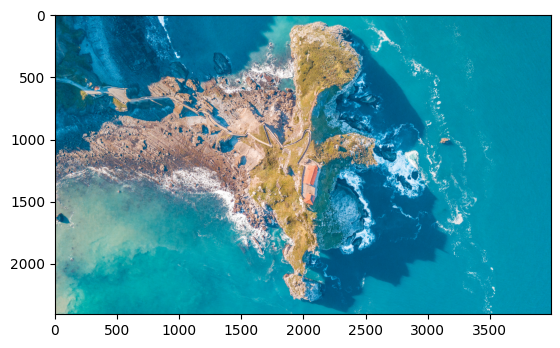

In [61]:
from matplotlib import pyplot as plt

#one_img = './1k/-bDYrrVAZnc.jpg'  # night
#one_img = './1k/-fjrjyS18BQ.jpg'  # dusk
#one_img = './1k/-N_UwPdUs7E.jpg'  # dawn
one_img = './1k/7kCNXfo35aU.jpg'  # day
#one_img = './1k/4_Bc9CSm70A.jpg'  # dusk or dawn

im = Image.open(one_img)
plt.imshow(im)

In [62]:
image = preprocess(Image.open(one_img)).unsqueeze(0).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    
    print( logits_per_image)
    print(logits_per_text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)
choices = np.argmax(probs)
labels[choices]

tensor([[21.7344, 23.5781, 20.3906, 20.8906]], device='mps:0',
       dtype=torch.float16)
tensor([[21.7344],
        [23.5781],
        [20.3906],
        [20.8906]], device='mps:0', dtype=torch.float16)
Label probs: [[0.1248  0.789   0.03256 0.05368]]


'day'

In [63]:
# search

In [64]:
# image captioning


In [15]:
import transformers
import datasets
import numpy as np
import pandas as pd
import torch
from PIL import Image
import requests

from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel

ModuleNotFoundError: No module named 'transformers'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "openai/clip-vit-base-patch32"

# we initialize a tokenizer, image processor, and the model itself
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)
model = CLIPModel.from_pretrained(model_id).to(device)

In [ ]:
urls=['https://images.unsplash.com/photo-1662955676669-c5d141718bfd?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=687&q=80',
    'https://images.unsplash.com/photo-1552053831-71594a27632d?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=662&q=80',
    'https://images.unsplash.com/photo-1530281700549-e82e7bf110d6?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=688&q=80']

images=[Image.open(requests.get(i, stream=True).raw)  for i in urls]

In [ ]:
text_prompts=["a girl wearing a beanie", "a boy wearing a beanie", "a dog", "a dog at the beach"]
inputs = inputs = processor(text=text_prompts, images=images, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image 
probs = logits_per_image.softmax(dim=1) 

In [ ]:
pd.DataFrame(probs.detach().numpy()*100, columns=text_prompts, index=list(['image1','image2', 'image3'])).style.background_gradient(axis=None,low=0, high=0.91).format(precision=2)